**TP2 - Adversarial Attack**

Binôme Stéphanie ROUXEL / Hy-Boui CHANG
Executive Master IASD 2019/2020


![Le logo de Framasoft](https://crowdai-shared.s3.eu-central-1.amazonaws.com/markdown_editor/ba0e38f517ff26613f4c225aed4f3b51_competition_illustration.png "perturbations")

Nous commençons par charger toutes les librairies nécessaires.

In [ ]:
# [CELL ID] 1

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

[CELL ID] 2
## Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks. 

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

[CELL ID] 3
## Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima. 

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network? 

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought. 

[CELL ID] 4
## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



[CELL ID 5]
### The Fast Gradient Sign Method (FGSM)

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Exercice 2
1. Define a neural network with 3 fully connected layers
2. Define a neural network with 2 convolutional layers and a last fully connected layer
2. Train the network on the full MNIST Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

On commence par charger les données dans le notebook.

In [ ]:
# [CELL ID] 6

# load MNIST dataset
def load_mnist(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.MNIST("./data", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

batch_size = 100
train_loader = load_mnist('train', batch_size)
test_loader = load_mnist('test', batch_size)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Regardons la taille des datasets

print(len(train_loader.dataset))
print(len(test_loader.dataset))

60000
60000


On définit si on va exécuter en mode CPU ou GPU.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Nous allons définir la fonction TRAIN_MODEL qui va nous permettre d'entrainer nos modèles. Nous choississons 10 epochs pour l'apprentissage.

*   x représente l'image
*   y représente le label associé
* yp représente la prédiction (le label prédict)


In [ ]:
# [CELL ID] 7


def train_model(model, criterion, optimizer, loader):

  epochs =10
    
  for epoch in range(epochs):

    total_loss, total_err, total_acc = 0.,0., 0.

    for X,y in loader:
          X,y = X.to(device), y.to(device)
          yp = model(X)
          loss = criterion(yp, y) 

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          total_err += (yp.max(dim=1)[1] != y).sum().item()
          total_acc += (yp.max(dim=1)[1] == y).sum().item()
          total_loss += loss.item() * X.shape[0]

    print('epoch {}, nb errors {}, dataset size {}, error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(epoch, total_err, len(loader.dataset), total_err/len(loader.dataset), total_acc/len(loader.dataset), total_loss/len(loader.dataset) ))



**1. Define a neural network with 3 fully connected layers**

Après avoir défini la fonction d'entrainement des modèles, nous allons créer les modèles. Le premier modèle sera un reseau de neurone avec 3 couches totalement connectées.

Nous avons besoin de créer au pré-alable une classe FLATTEN qui va aplatir les images.

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

Création de la classe définissant le modèle . 
Ce modèle est composé de 3 couches complétement connectées.


In [ ]:
# [CELL ID] 8

# define a neural network with 3 fully connected layers
class FullyConnectedModel(torch.nn.Module):
  
  def __init__(self):
    super(FullyConnectedModel, self).__init__()
    
    self.layers = nn.Sequential(
        Flatten(),
        nn.Linear(784, 200),
        nn.ReLU(),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )
  

  def forward(self, x):
    x=self.layers(x)
    return x

**2. Define a neural network with 2 convolutional layers and a last fully connected layer**

Création de la classe définissant le modèle CONVOLUTIONNEL.
Il sera composé de 2 convolutions 2D (incluant un max pooling et un relu), puis nous terminons avec 2 couches totalement connectée et une couche de sortie finale 

NB : nous suivons les instructions en commentaire du code

In [ ]:
# [CELL ID] 9 
# convolutional model with 2 convolution, 2 max pooling layer, 3 fully connected layer
# the model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc

class ConvModel(torch.nn.Module):
  
    def __init__(self):

        super(ConvModel, self).__init__()

        self.layers = nn.Sequential(
        
        nn.Conv2d(1, 32, 3, padding=1),
        nn.MaxPool2d(2,2),
        nn.ReLU(),

        nn.Conv2d(32, 32, 3, padding = 1, stride = 2),
        nn.MaxPool2d(2,2),
        nn.ReLU(),

        Flatten(),

        nn.Linear(32*9,200),
        nn.ReLU(),
        nn.Linear(200,100),
        nn.ReLU(),
        nn.Linear(100,10)
    )


    def forward(self, x):
        x=self.layers(x)
        return x

**3. Train the network on the full MNIST Dataset**

Maintenant que nos deux modèles (fc et convolutionnels) sont créées, nous allons les entrainer sur les données MNIST que nous avons chargé.

**3.1. Entrainement du modèle fc**

Commençons par le modèle fc. Après avoir créé une instance, on l'entraine. Nous choississons 10 epochs.

In [ ]:
# [CELL ID] 10

fc_model = FullyConnectedModel().to(device) 

# define your loss function
criterion = torch.nn.CrossEntropyLoss() 

# define your optimizer
opt = torch.optim.SGD(fc_model.parameters(), lr=1e-1)

train_model(fc_model, criterion, opt, train_loader)

epoch 0, nb errors 9979.0, dataset size 60000, error: 0.166, accuracy : 0.834, loss 0.6084
epoch 1, nb errors 4174.0, dataset size 60000, error: 0.070, accuracy : 0.930, loss 0.2387
epoch 2, nb errors 2988.0, dataset size 60000, error: 0.050, accuracy : 0.950, loss 0.1707
epoch 3, nb errors 2335.0, dataset size 60000, error: 0.039, accuracy : 0.961, loss 0.1321
epoch 4, nb errors 1862.0, dataset size 60000, error: 0.031, accuracy : 0.969, loss 0.1059
epoch 5, nb errors 1557.0, dataset size 60000, error: 0.026, accuracy : 0.974, loss 0.0882
epoch 6, nb errors 1319.0, dataset size 60000, error: 0.022, accuracy : 0.978, loss 0.0744
epoch 7, nb errors 1162.0, dataset size 60000, error: 0.019, accuracy : 0.981, loss 0.0638
epoch 8, nb errors 981.0, dataset size 60000, error: 0.016, accuracy : 0.984, loss 0.0556
epoch 9, nb errors 856.0, dataset size 60000, error: 0.014, accuracy : 0.986, loss 0.0479


**3.2. Entrainement du modèle convolutionnel**

Nous entrainons maintenant le modèle convolutionnel.
Comme pour le modèle fc, nous créons l'instance, puis nous l'entrainons sur les données de training

In [ ]:
# [CELL ID] 11

conv_model = ConvModel().to(device) 

# define your loss function
criterion = torch.nn.CrossEntropyLoss()

# define your optimizer
opt = optim.SGD(conv_model.parameters(), lr=1e-1)

train_model(conv_model, criterion, opt, train_loader)   

epoch 0, nb errors 17787.0, dataset size 60000, error: 0.296, accuracy : 0.704, loss 0.9043
epoch 1, nb errors 2939.0, dataset size 60000, error: 0.049, accuracy : 0.951, loss 0.1530
epoch 2, nb errors 1915.0, dataset size 60000, error: 0.032, accuracy : 0.968, loss 0.1025
epoch 3, nb errors 1537.0, dataset size 60000, error: 0.026, accuracy : 0.974, loss 0.0825
epoch 4, nb errors 1237.0, dataset size 60000, error: 0.021, accuracy : 0.979, loss 0.0654
epoch 5, nb errors 1033.0, dataset size 60000, error: 0.017, accuracy : 0.983, loss 0.0544
epoch 6, nb errors 930.0, dataset size 60000, error: 0.015, accuracy : 0.985, loss 0.0477
epoch 7, nb errors 806.0, dataset size 60000, error: 0.013, accuracy : 0.987, loss 0.0418
epoch 8, nb errors 689.0, dataset size 60000, error: 0.011, accuracy : 0.989, loss 0.0366
epoch 9, nb errors 670.0, dataset size 60000, error: 0.011, accuracy : 0.989, loss 0.0347


**3.3. Evaluation de la performance des modèles entrainés**

Nous allons maintenant créer une classe qui va permettre d'évaluer la performance de nos modèles entrainés.

C'est l'objectif de la fonction EVAL_MODEL. Nous prévoyons tout de suite le cas de l'évaluation de la performance en cas d'attaque.

In [ ]:
# [CELL ID] 12

with torch.no_grad():

  def eval_model(model, loader, attack=None):

    total_loss, total_err, total_acc = 0., 0., 0.
    delta = 0.
      
    for X,y in loader:
          
      X,y = X.to(device), y.to(device)

      if attack != None :
        delta=attack.compute(X,y).to(device)

      else:
        delta=0

      yp=model(X+delta)
      loss = nn.CrossEntropyLoss()(yp, y)
            
      total_acc += (yp.max(dim=1)[1] == y).sum().item()
      total_err += (yp.max(dim=1)[1] != y).sum().item()
      total_loss += loss.item() * X.shape[0]
        
    return( total_err/len(loader.dataset), total_acc/len(loader.dataset), total_loss/len(loader.dataset) )
  

**4. L'attaque FAST GRADIENT SIGN METHOD (FGSM)**

Voici la classe qui permet de calculer la perturbation créée par le FGSM.

In [ ]:
# [CELL ID] 13

class FastGradientSignMethod():
  
    def __init__(self, model, eps):
        self.model=model
        self.eps=eps
  
    def compute(self, x, y):
        x,y = x.to(device), y.to(device)
        delta = torch.zeros_like(x, requires_grad=True)
        loss = nn.CrossEntropyLoss()(self.model(x + delta), y)
        loss.backward()
        return self.eps * delta.grad.detach().sign() 


**5. Evalution des modèles après attaque FGSM**

**5.1. FGSM sur le modèle fc entrainé**

Nous commençons par constater la baisse de performance de notre modèle fc, qui a été entrainé précédemment.

La performance de notre modèle qui était excellente, tombe très bas lorsque notre modèle fc est attaqué. Nous pouvons le constater avec les valeurs très basses de l'accuracy.

Nous créons l'attaque FGSM :

In [ ]:
eps=0.1
# on créé l'instance de la classe
fgsm = FastGradientSignMethod(fc_model, eps)

In [ ]:
eval_model_fc = eval_model(fc_model, test_loader)

error_fc_model=eval_model_fc[0]
accuracy_fc_model=eval_model_fc[1]
loss_fc_model=eval_model_fc[2]
print('linear model : error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_fc_model,accuracy_fc_model,loss_fc_model))

linear model : error: 0.011, accuracy : 0.989, loss 0.0390


In [ ]:
eval_model_fc_fgsm = eval_model(fc_model, test_loader, fgsm)

error_fc_model_under_fgsm=eval_model_fc_fgsm[0]
accuracy_fc_model_under_fgsm=eval_model_fc_fgsm[1]
loss_fc_model_under_fgsm=eval_model_fc_fgsm[2]
print('linear model under fgsm : error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_fc_model_under_fgsm,accuracy_fc_model_under_fgsm,loss_fc_model_under_fgsm))

linear model under fgsm : error: 0.950, accuracy : 0.050, loss 7.5756


**5.2. FGSM sur le modèle convolutionnel entrainé**

Il est nécessaire de lancer une nouvelle instance de FGSM, cette fois ci basée sur le modèle convolutionnel.

Nous évaluons ensuite les valeurs de performances AVANT et APRES l'attaque FGSM sur le modèle convolutionnel. Le modèle convolutionnel semble mieux résister aux attaques FGSM.

In [ ]:
eps=0.1
# on créé l'instance de la classe
fgsm2 = FastGradientSignMethod(conv_model, eps)

In [ ]:
eval_model_conv = eval_model(conv_model, test_loader)

error_conv_model=eval_model_conv[0]
accuracy_conv_model=eval_model_conv[1]
loss_conv_model=eval_model_conv[2]
print('convolutional model: error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_conv_model,accuracy_conv_model,loss_conv_model))

convolutional model: error: 0.010, accuracy : 0.990, loss 0.0310


In [ ]:
eval_model_conv_fgsm2 = eval_model(conv_model, test_loader, fgsm2)

error_conv_model_under_fgsm=eval_model_conv_fgsm2[0]
accuracy_conv_model_under_fgsm=eval_model_conv_fgsm2[1]
loss_conv_model_under_fgsm=eval_model_conv_fgsm2[2]
print('convolutional model under fgsm : error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_conv_model_under_fgsm,accuracy_conv_model_under_fgsm,loss_conv_model_under_fgsm))

convolutional model under fgsm : error: 0.418, accuracy : 0.582, loss 1.5370


fc**6. Visualisation des images attaquées par FGSM**

Nous souhaitons maintenant voir les images qui ont été attaquées.
Utilisons un PLOT pour cette visualisation.

**6.1. Images attaqués par le FGSM sur le modèle fc**

Nous affichons la prédition avec le modèle fc sur les images perturbées.

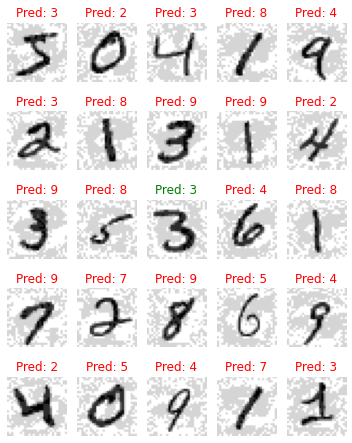

In [ ]:
# [CELL ID] 14

# Plot des images attaquées par le FGSM, et de la prédiction par le modèle fc

def plot_images(x, y, yp, M=5, N=5):
  x,y = x.to(device), y.to(device)
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N,M*1.3))
  for i in range(M):
    for j in range(N):
      ax[i][j].imshow(1-x[i*N+j][0], cmap="gray")
      title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()
  
for imgs, labels in test_loader:
  imgs, labels = imgs.to(device), labels.to(device)
  break

# with adversarial attack
delta = fgsm.compute(imgs, labels).to(device)

output = fc_model(imgs + delta)
plot_images(imgs+delta, labels, output)

Pour rappel, lorsque les images ne subissent pas l'attaque, voici la prédition faites par le modèle fc.

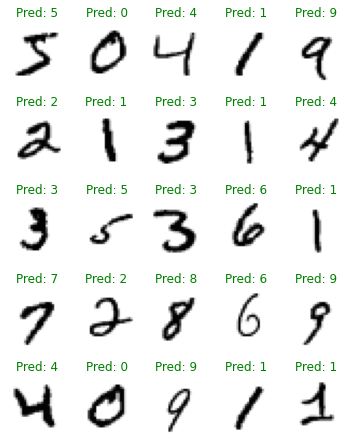

In [ ]:
# PLOT des images non attaquées et la prédiction par le modèle fc
output = fc_model(imgs)
plot_images(imgs, labels, output)

**6.2. Images attaqués par le FGSM sur le modèle convolutionnel**

Regardons maintenant les images qui sont attaquées par le FGSM sur le modèle convolutionnel.


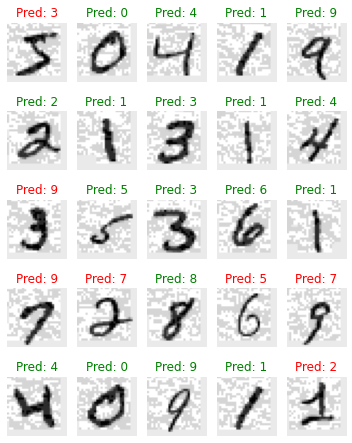

In [ ]:
# with adversarial attack
delta = fgsm2.compute(imgs, labels).to(device)

output = conv_model(imgs + delta)
plot_images(imgs+delta, labels, output)

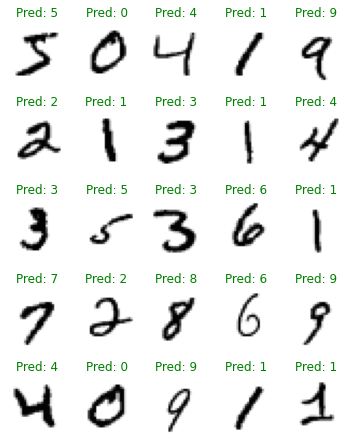

In [ ]:
# PLOT des images non attaquées et la prédiction par le modèle convolutionnel
output = conv_model(imgs)
plot_images(imgs, labels, output)

**7. Comparaison entre cette attaque FGSM et celle utilisée dans le notebook 1**

Dans le modèle linéaire du notebook 1, on a pu définir une attaque optimale et la perturbation est la même pour toutes les images.


Dans les réseaux de neurones du notebook 2, les attaques sont différentes car on n'a pas de solution optimale.
En revanche l'attaque FGSM ressemble beaucoup à l'attaque du notebook 1. Mais on se base ici sur une itération de la montée de gradient.


[CELL ID] 15

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

**1. L'attaque PGD**

Nous allons maintenant implémenter cette seconde attaque : le Projected Gradient Descent.

Commençons par définir la classe de PGD :

In [ ]:
# [CELL ID] 16

class ProjectedGradientDescent:
  
  def __init__(self, model, eps, alpha, num_iter):
    self.model=model
    self.eps=eps
    self.alpha=alpha
    self.num_iter=num_iter
  
  def compute(self, x, y):
    delta = torch.zeros_like(x, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(self.model(x + delta), y)
        loss.backward()
        delta.data = (delta + x.shape[0]*alpha*delta.grad.data).clamp(-eps,eps)
        delta.grad.zero_()
    return delta.detach()

Nous allons créer une instance de la classe PGD, et constater les impactes d'une attaque de PGD sur le modèle fc.

In [ ]:
# on créé l'instance de la classe, sur le modèle fc

eps=0.1
alpha=10000
num_iter=100
pgd = ProjectedGradientDescent(fc_model, eps, alpha, num_iter)


In [ ]:
eval_model_fc_pdg = eval_model(fc_model, test_loader, pgd)

error_fc_model_under_pgd=eval_model_fc_pdg[0]
accuracy_fc_model_under_pgd=eval_model_fc_pdg[1]
loss_fc_model_under_pgd=eval_model_fc_pdg[2]
print('Linear model under pgd : error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_fc_model_under_pgd,accuracy_fc_model_under_pgd,loss_fc_model_under_pgd))

Linear model under pgd : error: 0.983, accuracy : 0.017, loss 9.5461


Regardong comment les images sont impactées par le PGD :

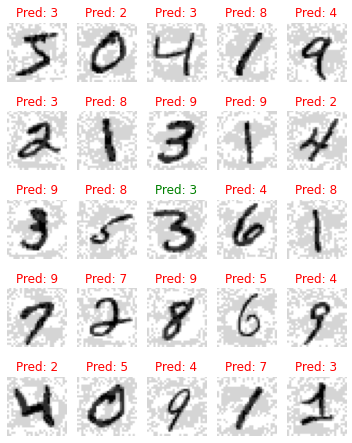

In [ ]:
# Plot des images attaquées par le PDG, et de la prédiction par le modèle fc

for imgs, labels in test_loader:
  imgs, labels = imgs.to(device), labels.to(device)
  break

delta = pgd.compute(imgs, labels)
output = fc_model(imgs + delta)
plot_images(imgs+delta, labels, output)

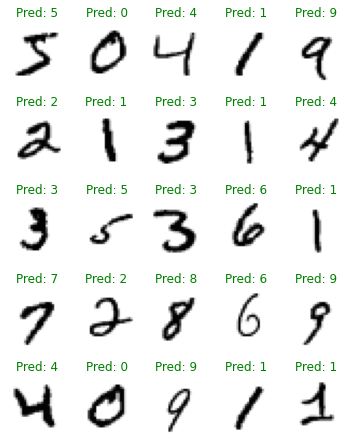

In [ ]:
#without adversarial
output = fc_model(imgs )
plot_images(imgs, labels, output)

Voici les différentes valeurs d'accuracy sur le modèle fc :


In [ ]:
print('sans attaque : accuracy : {:.3f}'.format(accuracy_fc_model))
print('avec attaque FGSM : accuracy : {:.3f}'.format(accuracy_fc_model_under_fgsm))
print('avec attaque PGD : accuracy : {:.3f}'.format(accuracy_fc_model_under_pgd))

sans attaque : accuracy : 0.989
avec attaque FGSM : accuracy : 0.050
avec attaque PGD : accuracy : 0.017




On constate que l'attaque PDG est un peu mieux que FGSM.

On relance une nouvelle instance de PGD, mais cette fois ci avec le modèle convolutionnel.

In [ ]:
eps=0.1
alpha=10000
num_iter=100
pgd2 = ProjectedGradientDescent(conv_model, eps, alpha, num_iter)

In [ ]:
eval_model_conv_pdg = eval_model(conv_model, test_loader, pgd2)

error_conv_model_under_pgd=eval_model_conv_pdg[0]
accuracy_conv_model_under_pgd=eval_model_conv_pdg[1]
loss_conv_model_under_pgd=eval_model_conv_pdg[2]
print('convolutional model under pgd : error: {:.3f}, accuracy : {:.3f}, loss {:.4f}'.format(error_conv_model_under_pgd,accuracy_conv_model_under_pgd,loss_conv_model_under_pgd))

convolutional model under pgd : error: 0.571, accuracy : 0.429, loss 2.2312


Visualisons les images attaquées par PDG sur la base du modèle convolutionnel :

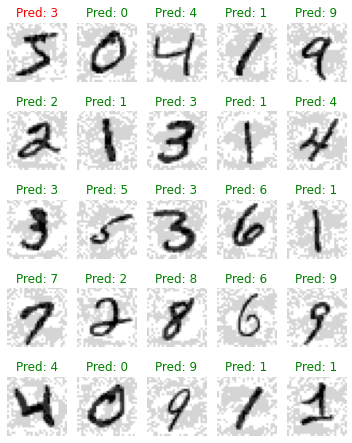

In [ ]:
# Plot des images attaquées par le PDG, et de la prédiction par le modèle convolutionnel

delta = pgd.compute(imgs, labels)
output = conv_model(imgs + delta)
plot_images(imgs+delta, labels, output)

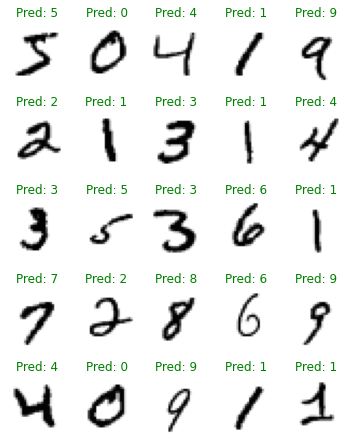

In [ ]:
#without adversarial
output = conv_model(imgs )
plot_images(imgs, labels, output)

In [ ]:
print('Convolutionnel sans attaque : accuracy : {:.3f}'.format(accuracy_conv_model))
print('Convolutionnel avec attaque FGSM : accuracy : {:.3f}'.format(accuracy_conv_model_under_fgsm))
print('Convolutionnel avec attaque PGD : accuracy : {:.3f}'.format(accuracy_conv_model_under_pgd))

Convolutionnel sans attaque : accuracy : 0.990
Convolutionnel avec attaque FGSM : accuracy : 0.582
Convolutionnel avec attaque PGD : accuracy : 0.429


On constate que l'attaque PDG est efficace sur les deux modèles, la gain en baisse d'accuracy comparée a la FGSM est encore plus fort sur le modèle convolutionnel. 
Le modèle convolutionnel resiste mieux aux attaques que pour le modèle fc.

In [ ]:
print('fc sans attaque : accuracy : {:.3f}'.format(accuracy_fc_model))
print('fc avec attaque FGSM : accuracy : {:.3f}'.format(accuracy_fc_model_under_fgsm))
print('fc avec attaque PGD : accuracy : {:.3f}'.format(accuracy_fc_model_under_pgd))


fc sans attaque : accuracy : 0.989
fc avec attaque FGSM : accuracy : 0.050
fc avec attaque PGD : accuracy : 0.017
